# Logic-Enhanced Foundation Models (LEFT) in ~ 100 Lines

LEFT is a unified concept learning and reasoning framework that flexibly learns concepts across domains and reasons across unseen tasks.
This notebook demonstrates how to use LEFT to learn and reason about simple shapes in 2D images, with a very small amount of code.

In [1]:
import sys
sys.path.append("/home/max/uni/LEFT/Jacinle")

import torch
import jacinle
import numpy as np
import torch.nn as nn
import jactorch

from typing import Optional, Union, List, Dict
from jacinle.config.environ_v2 import configs, set_configs
from left.domain import create_domain_from_parsing
from left.models.model import LeftModel


### Step 1: Load the simple shapes dataset.

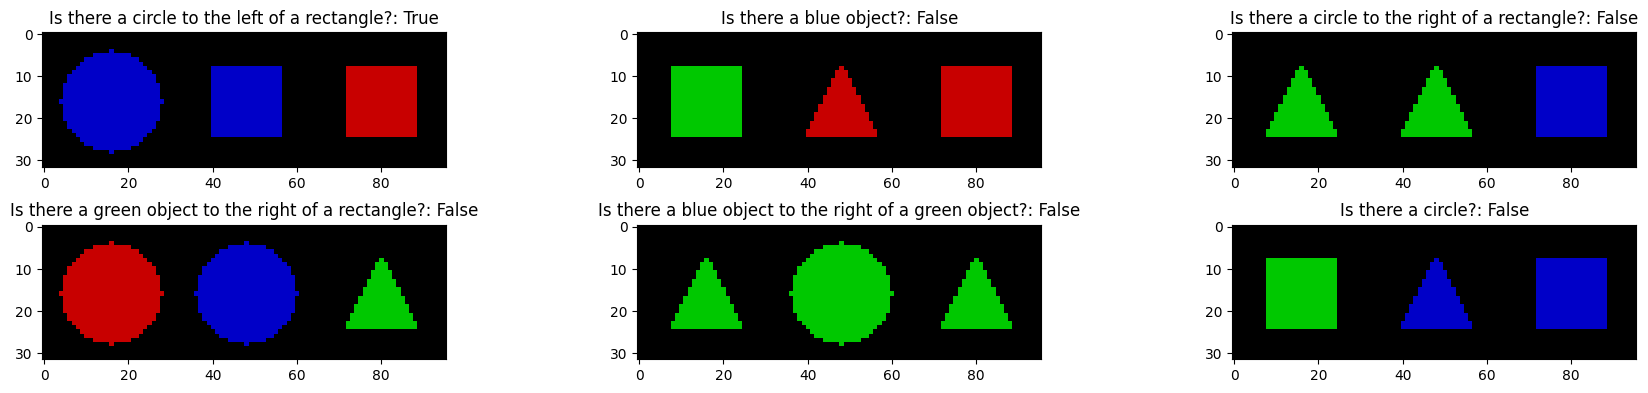

In [2]:
from concepts.benchmark.vision_language.shapes3.dataset import Shapes3Dataset
train_dataset = Shapes3Dataset(dataset_size=1024)  # create a dataset with 1024 samples
test_dataset = Shapes3Dataset(dataset_size=128)  # create a dataset with 128 samples for testing

# Now let's visualize a few samples from the dataset:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset[i]['image'].permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(train_dataset[i]['question'] + ': ' + str(train_dataset[i]['answer']))
plt.tight_layout()
plt.show()

### Step 2: Create the model.

Each model in LEFT is composed of:

- a visual feature extract that maps from images to a set of object features and their relational features.
- a concept embedding module that can classify objects and their relations into concepts. In this case, we will use a simple linear layer for all concepts.
- the program executor that takes a FOL program of the question as input, and generate the answer. This part is shared across all tasks, all domains, all modalities.

In [3]:
# Create the visual extractor. In this case, we will assume that we know each image is composed of three objects in a row.
# In general, we can use object detectors to extract the objects from the image.
# For each object, we will extract a 64-dimensional feature vector using a simple CNN.
# For each pair of objects, we will extract another 64-dimensional feature vector,
#   by using a simple lienar mapping from the concatenation of the two object features and their positional embeddings.

class ObjectCentricShapeEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.lenet = nn.Sequential(           # input is 1x32x32
            nn.Conv2d(3, 32, 5), nn.ReLU(),   # conv1: 32x28x28
            nn.MaxPool2d(2, 2),               # pool1: 32x14x14
            nn.Conv2d(32, 32, 5), nn.ReLU(),  # conv2: 32x10x10
            nn.MaxPool2d(2, 2),               # pool2: 32x5x5
        )
        self.fc = nn.Sequential(nn.Linear(32 * 5 * 5, 64), nn.ReLU())
        self.position_embedding = nn.Embedding(9, 64)
        self.fc2 = nn.Linear(256, 64)

    def forward(self, img):
        obj = self.forward_object(img)
        rel = self.forward_relation(obj)
        return obj, rel  # obj: [B, 3, 64], rel: [B, 3, 3, 64]

    def forward_object(self, img):
        # img = B, 3, 30, 30
        b = img.size(0)
        img = img.reshape((b, 3, 1, 32, 3, 32)).permute((0, 2, 4, 1, 3, 5)).reshape((b * 3, 3, 32, 32))
        img = self.lenet(img)
        img = img.reshape((b, 3, 32 * 25))
        img = self.fc(img)
        return img

    def forward_relation(self, object_feat):
        nr_objects = 3
        position_feature = torch.arange(nr_objects, dtype=torch.int64, device=object_feat.device)
        position_feature = self.position_embedding(position_feature)
        position_feature = position_feature.unsqueeze(0).expand(object_feat.size(0), nr_objects, 64)
        feature = torch.cat([object_feat, position_feature], dim=-1)

        feature1 = feature.unsqueeze(1).expand(feature.size(0), nr_objects, nr_objects, 128)
        feature2 = feature.unsqueeze(2).expand(feature.size(0), nr_objects, nr_objects, 128)
        feature = torch.cat([feature1, feature2], dim=-1)

        feature = self.fc2(feature)
        return feature

In [4]:
# Create a main model. You just need to implement the object-centric feature extractor, and a few other lines of code to processs each question in the batch.

with set_configs():
    configs.model.domain = 'shapes3'            # set to the name of the dataset
    configs.model.scene_graph = None            # set to the identifier of the scene graph extractor. In this case we will use our own implementation.
    configs.model.concept_embedding = 'linear'  # set to the identifier of the concept embedding. In this case we will use a simple linear mapping.
    configs.model.sg_dims = [None, 64, 64, 64]  # set to the dimensions of the object and relation features. In this case we will use 64-dimensional features for all of them.


class SimpleShapesModel(LeftModel):
    def __init__(self, domain, parses: Dict[str, Union[str, List[str]]], output_vocab):
        super().__init__(domain, output_vocab)

        self.parses = parses
        self.scene_graph = ObjectCentricShapeEmbedding()

    def forward(self, feed_dict):
        feed_dict = jacinle.GView(feed_dict)
        monitors, outputs = {}, {}

        f_sng = self.forward_sng(feed_dict)
        for i in range(len(feed_dict.question)):
            grounding = self.grounding_cls(f_sng[i], self, self.training, apply_relation_mask=True)
            question = feed_dict.question[i]
            raw_parsing = self.parses[question]
            raw_parsing = raw_parsing[0] if isinstance(raw_parsing, list) else raw_parsing
            # This will write to outputs['executions']
            print(raw_parsing)
            self.execute_program_from_parsing_string(question, raw_parsing, grounding, outputs)

        update_from_loss_module(monitors, outputs, self.qa_loss(outputs['executions'], feed_dict.answer, question_types=['bool' for _ in outputs['executions']]))

        if self.training:
            loss = monitors['loss/qa']
            return loss, monitors, outputs
        else:
            outputs['monitors'] = monitors
            return outputs

    def forward_sng(self, feed_dict):
        object_features, relation_features = self.scene_graph(feed_dict.image)
        all_scene_features = [{'attribute': object_features[i], 'relation': relation_features[i]} for i in range(len(object_features))]
        return all_scene_features


def update_from_loss_module(monitors, output_dict, loss_update):
    tmp_monitors, tmp_outputs = loss_update
    monitors.update(tmp_monitors)
    output_dict.update(tmp_outputs)

### Step 3: Training and evaluation.

In [5]:
language_to_program = {train_dataset[i]['question']: train_dataset[i]['program'] for i in range(len(train_dataset))}
language_to_program.update({test_dataset[i]['question']: test_dataset[i]['program'] for i in range(len(test_dataset))})

# In this example code, we will not be running GPT to parse the questions. Instead, we just use the groundtruth programs that come with the dataset.
# What you need is simple a dictionary that maps each question to its program.
# Visualize the first 6 questions and their programs.

for i in range(6):
    question = train_dataset[i]['question']
    print(question)
    print(language_to_program[question])

Is there a circle to the left of a rectangle?
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
Is there a blue object?
exists(Object, lambda x: blue(x))
Is there a circle to the right of a rectangle?
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
Is there a green object to the right of a rectangle?
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
Is there a blue object to the right of a green object?
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
Is there a circle?
exists(Object, lambda x: circle(x))


In [6]:
# Create a domain using all the parsed programs. It will automatically extract all concepts and relations from the programs.
domain = create_domain_from_parsing(language_to_program)

Creating domain from parsings: 100%|##########| 78/78 [00:00<00:00, 4500.14it/s]


In [7]:
# Visualize the domain. You can see that it has extracted all the concepts and relations from the programs.
domain.print_summary()

TypeSystem: Left
  Types:
    Object
    Object_Set
    Action
  Constants:
  Functions:
    equal(#0: int64, #1: int64) -> bool
    greater_than(#0: int64, #1: int64) -> bool
    less_than(#0: int64, #1: int64) -> bool
    circle_Object(#0: Object) -> bool
    left_Object_Object(#0: Object, #1: Object) -> bool
    rectangle_Object(#0: Object) -> bool
    blue_Object(#0: Object) -> bool
    right_Object_Object(#0: Object, #1: Object) -> bool
    green_Object(#0: Object) -> bool
    red_Object(#0: Object) -> bool
    triangle_Object(#0: Object) -> bool


In [8]:
func = domain.get_function("green_Object")
arg = func.arguments[0]
arg.typename

'Object'

In [9]:
# Define a helper function to update the meters.
def update_meters(meters, monitors, prefix: Optional[str] = None):
    for k in list(monitors.keys()):
        if k + '/n' in monitors:
            meters.update({k: monitors[k]}, n=monitors[k + '/n'], prefix=prefix)
            del monitors[k]
            del monitors[k + '/n']

    meters.update(monitors, prefix=prefix)

# Build the domain.
domain = create_domain_from_parsing(language_to_program)
domain.print_summary()

# Build the model.
model = SimpleShapesModel(domain, language_to_program, output_vocab=None)  # output vocab is not used (Boolean only)

# Build the optimizer.
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
group_meters = jacinle.GroupMeters()

nr_epochs = 8
for i in range(1, nr_epochs + 1):
    dataloader = train_dataset.make_dataloader(batch_size=16, shuffle=True, drop_last=True, nr_workers=0)
    model.train()
    group_meters.reset()
    for data in jacinle.tqdm(dataloader, total=len(dataloader), desc='Epoch {}'.format(i)):
        loss, monitors, outputs = model(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_meters(group_meters, {k: float(v) for k, v in monitors.items()})
        jacinle.get_current_tqdm().set_description(group_meters.format_simple(f'Epoch {i}', compressed=True))

    # print(group_meters.format_simple(f'Epoch {i}', compressed=False))

    dataloader = test_dataset.make_dataloader(batch_size=16, shuffle=False, drop_last=False, nr_workers=0)
    model.eval()
    group_meters.reset()
    with torch.no_grad():
        for data in jacinle.tqdm(dataloader, total=len(dataloader), desc='Epoch {} (test)'.format(i)):
            outputs = model(data)
            update_meters(group_meters, {k: float(v) for k, v in outputs['monitors'].items()})
            jacinle.get_current_tqdm().set_description(group_meters.format_simple(f'Epoch {i} (test)', compressed=True))

    print(group_meters.format_simple(f'Epoch {i} (test)', compressed=False))

Creating domain from parsings: 100%|##########| 78/78 [00:00<00:00, 6274.20it/s]
21 18:06:19 Function equal automatically registered.
21 18:06:19 Function greater_than automatically registered.
21 18:06:19 Function less_than automatically registered.


TypeSystem: Left
  Types:
    Object
    Object_Set
    Action
  Constants:
  Functions:
    equal(#0: int64, #1: int64) -> bool
    greater_than(#0: int64, #1: int64) -> bool
    less_than(#0: int64, #1: int64) -> bool
    circle_Object(#0: Object) -> bool
    left_Object_Object(#0: Object, #1: Object) -> bool
    rectangle_Object(#0: Object) -> bool
    blue_Object(#0: Object) -> bool
    right_Object_Object(#0: Object, #1: Object) -> bool
    green_Object(#0: Object) -> bool
    red_Object(#0: Object) -> bool
    triangle_Object(#0: Object) -> bool


Epoch 1 acc/qa=0.531250 acc/qa/bool=0.531250 acc/qa_succ_exec=0.531250 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_O

Epoch 1 acc/qa=0.464286 acc/qa/bool=0.464286 acc/qa_succ_exec=0.464286 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_di

Epoch 1 acc/qa=0.528846 acc/qa/bool=0.528846 acc/qa_succ_exec=0.528846 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_O

Epoch 1 acc/qa=0.559028 acc/qa/bool=0.559028 acc/qa_succ_exec=0.559028 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['

Epoch 1 acc/qa=0.592391 acc/qa/bool=0.592391 acc/qa_succ_exec=0.592391 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Obj

Epoch 1 acc/qa=0.618304 acc/qa/bool=0.618304 acc/qa_succ_exec=0.618304 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object -

Epoch 1 acc/qa=0.626894 acc/qa/bool=0.626894 acc/qa_succ_exec=0.626894 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_d

Epoch 1 acc/qa=0.636824 acc/qa/bool=0.636824 acc/qa_succ_exec=0.636824 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'

Epoch 1 acc/qa=0.654762 acc/qa/bool=0.654762 acc/qa_succ_exec=0.654762 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_

Epoch 1 acc/qa=0.658854 acc/qa/bool=0.658854 acc/qa_succ_exec=0.658854 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': 

Epoch 1 acc/qa=0.660539 acc/qa/bool=0.660539 acc/qa_succ_exec=0.660539 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'righ

Epoch 1 acc/qa=0.660227 acc/qa/bool=0.660227 acc/qa_succ_exec=0.660227 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - gree

Epoch 1 acc/qa=0.666667 acc/qa/bool=0.666667 acc/qa_succ_exec=0.666667 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_

Epoch 1 acc/qa=0.667969 acc/qa/bool=0.667969 acc/qa_succ_exec=0.667969 acc/succe


exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim'

Epoch 1 (test) acc/qa=0.770833 acc/qa/bool=0.770833 acc/qa_succ_exec=0.770833 ac

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 1 (test) acc/qa=0.664062 acc/qa/bool=0.664062 acc/qa_succ_exec=0.664062 ac


2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'gree

Epoch 2:   0%|                                           | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green

Epoch 2 acc/qa=0.656250 acc/qa/bool=0.656250 acc/qa_succ_exec=0.656250 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': Non

Epoch 2 acc/qa=0.712500 acc/qa/bool=0.712500 acc/qa_succ_exec=0.712500 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - ci

Epoch 2 acc/qa=0.687500 acc/qa/bool=0.687500 acc/qa_succ_exec=0.687500 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attri

Epoch 2 acc/qa=0.736111 acc/qa/bool=0.736111 acc/qa_succ_exec=0.736111 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_

Epoch 2 acc/qa=0.738636 acc/qa/bool=0.738636 acc/qa_succ_exec=0.738636 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object',

Epoch 2 acc/qa=0.712500 acc/qa/bool=0.712500 acc/qa_succ_exec=0.712500 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Ob

Epoch 2 acc/qa=0.713235 acc/qa/bool=0.713235 acc/qa_succ_exec=0.713235 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 

Epoch 2 acc/qa=0.700000 acc/qa/bool=0.700000 acc/qa_succ_exec=0.700000 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Obj

Epoch 2 acc/qa=0.713068 acc/qa/bool=0.713068 acc/qa_succ_exec=0.713068 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'a

Epoch 2 acc/qa=0.707500 acc/qa/bool=0.707500 acc/qa_succ_exec=0.707500 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object -

Epoch 2 acc/qa=0.708333 acc/qa/bool=0.708333 acc/qa_succ_exec=0.708333 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 6

Epoch 2 acc/qa=0.715517 acc/qa/bool=0.715517 acc/qa_succ_exec=0.715517 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_outpu

Epoch 2 acc/qa=0.705645 acc/qa/bool=0.705645 acc/qa_succ_exec=0.705645 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute

Epoch 2 acc/qa=0.712500 acc/qa/bool=0.712500 acc/qa_succ_exec=0.712500 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object

Epoch 2 acc/qa=0.717905 acc/qa/bool=0.717905 acc/qa_succ_exec=0.717905 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attr

Epoch 2 acc/qa=0.720313 acc/qa/bool=0.720313 acc/qa_succ_exec=0.720313 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_O

Epoch 2 acc/qa=0.717988 acc/qa/bool=0.717988 acc/qa_succ_exec=0.717988 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim

Epoch 2 acc/qa=0.716667 acc/qa/bool=0.716667 acc/qa_succ_exec=0.716667 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_

Epoch 2 acc/qa=0.717391 acc/qa/bool=0.717391 acc/qa_succ_exec=0.717391 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object',

Epoch 2 acc/qa=0.724265 acc/qa/bool=0.724265 acc/qa_succ_exec=0.724265 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Ob

Epoch 2 acc/qa=0.723558 acc/qa/bool=0.723558 acc/qa_succ_exec=0.723558 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - righ

Epoch 2 acc/qa=0.729167 acc/qa/bool=0.729167 acc/qa_succ_exec=0.729167 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', '

Epoch 2 acc/qa=0.729526 acc/qa/bool=0.729526 acc/qa_succ_exec=0.729526 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_

Epoch 2 acc/qa=0.725806 acc/qa/bool=0.725806 acc/qa_succ_exec=0.725806 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Obje

Epoch 2 acc/qa=0.725198 acc/qa/bool=0.725198 acc/qa_succ_exec=0.725198 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'r

Epoch 2 acc/qa=0.724609 acc/qa/bool=0.724609 acc/qa_succ_exec=0.724609 acc/succe


2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_O

Epoch 2 (test) acc/qa=0.750000 acc/qa/bool=0.750000 acc/qa_succ_exec=0.750000 ac

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 2 (test) acc/qa=0.696429 acc/qa/bool=0.696429 acc/qa_succ_exec=0.696429 ac

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 

Epoch 2 (test) acc/qa=0.687500 acc/qa/bool=0.687500 acc/qa_succ_exec=0.687500 ac


exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object'

Epoch 3:   0%|                                           | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute

Epoch 3 acc/qa=0.770833 acc/qa/bool=0.770833 acc/qa_succ_exec=0.770833 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Objec

Epoch 3 acc/qa=0.750000 acc/qa/bool=0.750000 acc/qa_succ_exec=0.750000 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: gree

Epoch 3 acc/qa=0.775000 acc/qa/bool=0.775000 acc/qa_succ_exec=0.775000 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([

Epoch 3 acc/qa=0.750000 acc/qa/bool=0.750000 acc/qa_succ_exec=0.750000 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Objec

Epoch 3 acc/qa=0.750000 acc/qa/bool=0.750000 acc/qa_succ_exec=0.750000 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribu

Epoch 3 acc/qa=0.743056 acc/qa/bool=0.743056 acc/qa_succ_exec=0.743056 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': N

Epoch 3 acc/qa=0.755682 acc/qa/bool=0.755682 acc/qa_succ_exec=0.755682 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_

Epoch 3 acc/qa=0.764423 acc/qa/bool=0.764423 acc/qa_succ_exec=0.764423 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attr

Epoch 3 acc/qa=0.776786 acc/qa/bool=0.776786 acc/qa_succ_exec=0.776786 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_O

Epoch 3 acc/qa=0.758333 acc/qa/bool=0.758333 acc/qa_succ_exec=0.758333 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, '

Epoch 3 acc/qa=0.750000 acc/qa/bool=0.750000 acc/qa_succ_exec=0.750000 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'a

Epoch 3 acc/qa=0.746528 acc/qa/bool=0.746528 acc/qa_succ_exec=0.746528 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - c

Epoch 3 acc/qa=0.743421 acc/qa/bool=0.743421 acc/qa_succ_exec=0.743421 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red

Epoch 3 acc/qa=0.753125 acc/qa/bool=0.753125 acc/qa_succ_exec=0.753125 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim'

Epoch 3 acc/qa=0.747159 acc/qa/bool=0.747159 acc/qa_succ_exec=0.747159 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, '

Epoch 3 acc/qa=0.747283 acc/qa/bool=0.747283 acc/qa_succ_exec=0.747283 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_O

Epoch 3 acc/qa=0.752604 acc/qa/bool=0.752604 acc/qa_succ_exec=0.752604 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: b

Epoch 3 acc/qa=0.757212 acc/qa/bool=0.757212 acc/qa_succ_exec=0.757212 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Objec

Epoch 3 acc/qa=0.759259 acc/qa/bool=0.759259 acc/qa_succ_exec=0.759259 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim'

Epoch 3 acc/qa=0.763393 acc/qa/bool=0.763393 acc/qa_succ_exec=0.763393 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'g

Epoch 3 acc/qa=0.769397 acc/qa/bool=0.769397 acc/qa_succ_exec=0.769397 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_O

Epoch 3 acc/qa=0.773438 acc/qa/bool=0.773438 acc/qa_succ_exec=0.773438 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Objec

Epoch 3 acc/qa=0.776515 acc/qa/bool=0.776515 acc/qa_succ_exec=0.776515 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Obje

Epoch 3 acc/qa=0.767857 acc/qa/bool=0.767857 acc/qa_succ_exec=0.767857 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'a

Epoch 3 acc/qa=0.765625 acc/qa/bool=0.765625 acc/qa_succ_exec=0.765625 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim

Epoch 3 acc/qa=0.765203 acc/qa/bool=0.765203 acc/qa_succ_exec=0.765203 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Obj

Epoch 3 acc/qa=0.762821 acc/qa/bool=0.762821 acc/qa_succ_exec=0.762821 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 're

Epoch 3 acc/qa=0.760938 acc/qa/bool=0.760938 acc/qa_succ_exec=0.760938 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Objec

Epoch 3 acc/qa=0.756098 acc/qa/bool=0.756098 acc/qa_succ_exec=0.756098 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim'

Epoch 3 acc/qa=0.752907 acc/qa/bool=0.752907 acc/qa_succ_exec=0.752907 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - t

Epoch 3 acc/qa=0.755682 acc/qa/bool=0.755682 acc/qa_succ_exec=0.755682 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'tri

Epoch 3 acc/qa=0.755435 acc/qa/bool=0.755435 acc/qa_succ_exec=0.755435 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64,

Epoch 3 acc/qa=0.757979 acc/qa/bool=0.757979 acc/qa_succ_exec=0.757979 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, '

Epoch 3 acc/qa=0.757653 acc/qa/bool=0.757653 acc/qa_succ_exec=0.757653 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Obj

Epoch 3 acc/qa=0.761250 acc/qa/bool=0.761250 acc/qa_succ_exec=0.761250 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 't

Epoch 3 acc/qa=0.760817 acc/qa/bool=0.760817 acc/qa_succ_exec=0.760817 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'at

Epoch 3 acc/qa=0.761792 acc/qa/bool=0.761792 acc/qa_succ_exec=0.761792 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Obje

Epoch 3 acc/qa=0.760227 acc/qa/bool=0.760227 acc/qa_succ_exec=0.760227 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64,

Epoch 3 acc/qa=0.761161 acc/qa/bool=0.761161 acc/qa_succ_exec=0.761161 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Objec

Epoch 3 acc/qa=0.762931 acc/qa/bool=0.762931 acc/qa_succ_exec=0.762931 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - le

Epoch 3 acc/qa=0.760593 acc/qa/bool=0.760593 acc/qa_succ_exec=0.760593 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object

Epoch 3 acc/qa=0.761270 acc/qa/bool=0.761270 acc/qa_succ_exec=0.761270 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Si

Epoch 3 acc/qa=0.763105 acc/qa/bool=0.763105 acc/qa_succ_exec=0.763105 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64

Epoch 3 acc/qa=0.759921 acc/qa/bool=0.759921 acc/qa_succ_exec=0.759921 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object'

Epoch 3 acc/qa=0.759766 acc/qa/bool=0.759766 acc/qa_succ_exec=0.759766 acc/succe
Epoch 3 (test) acc/qa=0.762500 acc/qa/bool=0.762500 acc/qa_succ_exec=0.762500 ac

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 3 (test) acc/qa=0.714286 acc/qa/bool=0.714286 acc/qa_succ_exec=0.714286 ac

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambd

Epoch 3 (test) acc/qa=0.695312 acc/qa/bool=0.695312 acc/qa_succ_exec=0.695312 ac


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_O

Epoch 4:   0%|                                           | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_O

Epoch 4 acc/qa=0.671875 acc/qa/bool=0.671875 acc/qa_succ_exec=0.671875 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear

Epoch 4 acc/qa=0.687500 acc/qa/bool=0.687500 acc/qa_succ_exec=0.687500 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_

Epoch 4 acc/qa=0.708333 acc/qa/bool=0.708333 acc/qa_succ_exec=0.708333 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 

Epoch 4 acc/qa=0.715278 acc/qa/bool=0.715278 acc/qa_succ_exec=0.715278 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_d

Epoch 4 acc/qa=0.715278 acc/qa/bool=0.715278 acc/qa_succ_exec=0.715278 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_O

Epoch 4 acc/qa=0.718750 acc/qa/bool=0.718750 acc/qa_succ_exec=0.718750 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Objec

Epoch 4 acc/qa=0.704545 acc/qa/bool=0.704545 acc/qa_succ_exec=0.704545 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object 

Epoch 4 acc/qa=0.697115 acc/qa/bool=0.697115 acc/qa_succ_exec=0.697115 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Ob

Epoch 4 acc/qa=0.696429 acc/qa/bool=0.696429 acc/qa_succ_exec=0.696429 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Ob

Epoch 4 acc/qa=0.718750 acc/qa/bool=0.718750 acc/qa_succ_exec=0.718750 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Objec

Epoch 4 acc/qa=0.720588 acc/qa/bool=0.720588 acc/qa_succ_exec=0.720588 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Obje

Epoch 4 acc/qa=0.720395 acc/qa/bool=0.720395 acc/qa_succ_exec=0.720395 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circ

Epoch 4 acc/qa=0.731250 acc/qa/bool=0.731250 acc/qa_succ_exec=0.731250 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_

Epoch 4 acc/qa=0.738095 acc/qa/bool=0.738095 acc/qa_succ_exec=0.738095 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 

Epoch 4 acc/qa=0.730114 acc/qa/bool=0.730114 acc/qa_succ_exec=0.730114 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_inpu

Epoch 4 acc/qa=0.739583 acc/qa/bool=0.739583 acc/qa_succ_exec=0.739583 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Ob

Epoch 4 acc/qa=0.730000 acc/qa/bool=0.730000 acc/qa_succ_exec=0.730000 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attrib

Epoch 4 acc/qa=0.723558 acc/qa/bool=0.723558 acc/qa_succ_exec=0.723558 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Ob

Epoch 4 acc/qa=0.724537 acc/qa/bool=0.724537 acc/qa_succ_exec=0.724537 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Obje

Epoch 4 acc/qa=0.733333 acc/qa/bool=0.733333 acc/qa_succ_exec=0.733333 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_inpu

Epoch 4 acc/qa=0.731855 acc/qa/bool=0.731855 acc/qa_succ_exec=0.731855 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input

Epoch 4 acc/qa=0.740234 acc/qa/bool=0.740234 acc/qa_succ_exec=0.740234 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_O

Epoch 4 acc/qa=0.742424 acc/qa/bool=0.742424 acc/qa_succ_exec=0.742424 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, '

Epoch 4 acc/qa=0.742857 acc/qa/bool=0.742857 acc/qa_succ_exec=0.742857 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_O

Epoch 4 acc/qa=0.743056 acc/qa/bool=0.743056 acc/qa_succ_exec=0.743056 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64,

Epoch 4 acc/qa=0.741776 acc/qa/bool=0.741776 acc/qa_succ_exec=0.741776 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute

Epoch 4 acc/qa=0.746875 acc/qa/bool=0.746875 acc/qa_succ_exec=0.746875 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_

Epoch 4 acc/qa=0.750000 acc/qa/bool=0.750000 acc/qa_succ_exec=0.750000 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'at

Epoch 4 acc/qa=0.747159 acc/qa/bool=0.747159 acc/qa_succ_exec=0.747159 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Objec

Epoch 4 acc/qa=0.751389 acc/qa/bool=0.751389 acc/qa_succ_exec=0.751389 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': 

Epoch 4 acc/qa=0.751359 acc/qa/bool=0.751359 acc/qa_succ_exec=0.751359 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Ob

Epoch 4 acc/qa=0.751330 acc/qa/bool=0.751330 acc/qa_succ_exec=0.751330 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}


Epoch 4 acc/qa=0.746173 acc/qa/bool=0.746173 acc/qa_succ_exec=0.746173 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute

Epoch 4 acc/qa=0.748750 acc/qa/bool=0.748750 acc/qa_succ_exec=0.748750 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribut

Epoch 4 acc/qa=0.745098 acc/qa/bool=0.745098 acc/qa_succ_exec=0.745098 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 6

Epoch 4 acc/qa=0.746394 acc/qa/bool=0.746394 acc/qa_succ_exec=0.746394 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'tria

Epoch 4 acc/qa=0.751157 acc/qa/bool=0.751157 acc/qa_succ_exec=0.751157 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object

Epoch 4 acc/qa=0.751136 acc/qa/bool=0.751136 acc/qa_succ_exec=0.751136 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Ob

Epoch 4 acc/qa=0.754464 acc/qa/bool=0.754464 acc/qa_succ_exec=0.754464 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Ob

Epoch 4 acc/qa=0.756466 acc/qa/bool=0.756466 acc/qa_succ_exec=0.756466 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attr

Epoch 4 acc/qa=0.755297 acc/qa/bool=0.755297 acc/qa_succ_exec=0.755297 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectan

Epoch 4 acc/qa=0.753125 acc/qa/bool=0.753125 acc/qa_succ_exec=0.753125 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'r

Epoch 4 acc/qa=0.755123 acc/qa/bool=0.755123 acc/qa_succ_exec=0.755123 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right

Epoch 4 acc/qa=0.752016 acc/qa/bool=0.752016 acc/qa_succ_exec=0.752016 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_

Epoch 4 acc/qa=0.754883 acc/qa/bool=0.754883 acc/qa_succ_exec=0.754883 acc/succe


exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Obj

Epoch 4 (test) acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 ac

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 4 (test) acc/qa=0.843750 acc/qa/bool=0.843750 acc/qa_succ_exec=0.843750 ac

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', '

Epoch 4 (test) acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 ac


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1

Epoch 5 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Obje

Epoch 5 acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object'

Epoch 5 acc/qa=0.833333 acc/qa/bool=0.833333 acc/qa_succ_exec=0.833333 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exi

Epoch 5 acc/qa=0.837500 acc/qa/bool=0.837500 acc/qa_succ_exec=0.837500 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim':

Epoch 5 acc/qa=0.843750 acc/qa/bool=0.843750 acc/qa_succ_exec=0.843750 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64,

Epoch 5 acc/qa=0.848214 acc/qa/bool=0.848214 acc/qa_succ_exec=0.848214 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_outpu

Epoch 5 acc/qa=0.854167 acc/qa/bool=0.854167 acc/qa_succ_exec=0.854167 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_O

Epoch 5 acc/qa=0.848958 acc/qa/bool=0.848958 acc/qa_succ_exec=0.848958 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}


Epoch 5 acc/qa=0.850962 acc/qa/bool=0.850962 acc/qa_succ_exec=0.850962 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim':

Epoch 5 acc/qa=0.852679 acc/qa/bool=0.852679 acc/qa_succ_exec=0.852679 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Objec

Epoch 5 acc/qa=0.832031 acc/qa/bool=0.832031 acc/qa_succ_exec=0.832031 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Obj

Epoch 5 acc/qa=0.823529 acc/qa/bool=0.823529 acc/qa_succ_exec=0.823529 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 

Epoch 5 acc/qa=0.815972 acc/qa/bool=0.815972 acc/qa_succ_exec=0.815972 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], '

Epoch 5 acc/qa=0.818750 acc/qa/bool=0.818750 acc/qa_succ_exec=0.818750 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Obj

Epoch 5 acc/qa=0.824405 acc/qa/bool=0.824405 acc/qa_succ_exec=0.824405 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Objec

Epoch 5 acc/qa=0.826705 acc/qa/bool=0.826705 acc/qa_succ_exec=0.826705 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_inpu

Epoch 5 acc/qa=0.820312 acc/qa/bool=0.820312 acc/qa_succ_exec=0.820312 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Obje

Epoch 5 acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_inp

Epoch 5 acc/qa=0.805556 acc/qa/bool=0.805556 acc/qa_succ_exec=0.805556 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Ob

Epoch 5 acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', '

Epoch 5 acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_O

Epoch 5 acc/qa=0.816288 acc/qa/bool=0.816288 acc/qa_succ_exec=0.816288 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_O

Epoch 5 acc/qa=0.810714 acc/qa/bool=0.810714 acc/qa_succ_exec=0.810714 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_

Epoch 5 acc/qa=0.809028 acc/qa/bool=0.809028 acc/qa_succ_exec=0.809028 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Ob

Epoch 5 acc/qa=0.809295 acc/qa/bool=0.809295 acc/qa_succ_exec=0.809295 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Obje

Epoch 5 acc/qa=0.806402 acc/qa/bool=0.806402 acc/qa_succ_exec=0.806402 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x

Epoch 5 acc/qa=0.806686 acc/qa/bool=0.806686 acc/qa_succ_exec=0.806686 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'a

Epoch 5 acc/qa=0.808333 acc/qa/bool=0.808333 acc/qa_succ_exec=0.808333 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left

Epoch 5 acc/qa=0.811198 acc/qa/bool=0.811198 acc/qa_succ_exec=0.811198 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attr

Epoch 5 acc/qa=0.808750 acc/qa/bool=0.808750 acc/qa_succ_exec=0.808750 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_

Epoch 5 acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right

Epoch 5 acc/qa=0.814815 acc/qa/bool=0.814815 acc/qa_succ_exec=0.814815 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object

Epoch 5 acc/qa=0.816964 acc/qa/bool=0.816964 acc/qa_succ_exec=0.816964 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_

Epoch 5 acc/qa=0.813578 acc/qa/bool=0.813578 acc/qa_succ_exec=0.813578 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_O

Epoch 5 acc/qa=0.814583 acc/qa/bool=0.814583 acc/qa_succ_exec=0.814583 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - 

Epoch 5 acc/qa=0.814549 acc/qa/bool=0.814549 acc/qa_succ_exec=0.814549 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Obje

Epoch 5 acc/qa=0.814484 acc/qa/bool=0.814484 acc/qa_succ_exec=0.814484 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Objec

Epoch 5 acc/qa=0.815430 acc/qa/bool=0.815430 acc/qa_succ_exec=0.815430 acc/succe
Epoch 5 (test) acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 ac

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 5 (test) acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 ac

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', '

Epoch 5 (test) acc/qa=0.866071 acc/qa/bool=0.866071 acc/qa_succ_exec=0.866071 ac

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_

Epoch 5 (test) acc/qa=0.867188 acc/qa/bool=0.867188 acc/qa_succ_exec=0.867188 ac


exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object'

Epoch 6:   0%|                                           | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', '

Epoch 6 acc/qa=0.843750 acc/qa/bool=0.843750 acc/qa_succ_exec=0.843750 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object',

Epoch 6 acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_O

Epoch 6 acc/qa=0.848214 acc/qa/bool=0.848214 acc/qa_succ_exec=0.848214 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_O

Epoch 6 acc/qa=0.868056 acc/qa/bool=0.868056 acc/qa_succ_exec=0.868056 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_ou

Epoch 6 acc/qa=0.856250 acc/qa/bool=0.856250 acc/qa_succ_exec=0.856250 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_

Epoch 6 acc/qa=0.869792 acc/qa/bool=0.869792 acc/qa_succ_exec=0.869792 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object

Epoch 6 acc/qa=0.879167 acc/qa/bool=0.879167 acc/qa_succ_exec=0.879167 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_

Epoch 6 acc/qa=0.885417 acc/qa/bool=0.885417 acc/qa_succ_exec=0.885417 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object

Epoch 6 acc/qa=0.887500 acc/qa/bool=0.887500 acc/qa_succ_exec=0.887500 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_

Epoch 6 acc/qa=0.889881 acc/qa/bool=0.889881 acc/qa_succ_exec=0.889881 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x:

Epoch 6 acc/qa=0.885870 acc/qa/bool=0.885870 acc/qa_succ_exec=0.885870 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Obj

Epoch 6 acc/qa=0.887500 acc/qa/bool=0.887500 acc/qa_succ_exec=0.887500 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object

Epoch 6 acc/qa=0.889423 acc/qa/bool=0.889423 acc/qa_succ_exec=0.889423 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'tria

Epoch 6 acc/qa=0.885776 acc/qa/bool=0.885776 acc/qa_succ_exec=0.885776 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Ob

Epoch 6 acc/qa=0.885081 acc/qa/bool=0.885081 acc/qa_succ_exec=0.885081 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64

Epoch 6 acc/qa=0.880859 acc/qa/bool=0.880859 acc/qa_succ_exec=0.880859 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'at

Epoch 6 acc/qa=0.878676 acc/qa/bool=0.878676 acc/qa_succ_exec=0.878676 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Obje

Epoch 6 acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attr

Epoch 6 acc/qa=0.876645 acc/qa/bool=0.876645 acc/qa_succ_exec=0.876645 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute

Epoch 6 acc/qa=0.871951 acc/qa/bool=0.871951 acc/qa_succ_exec=0.871951 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 're

Epoch 6 acc/qa=0.873512 acc/qa/bool=0.873512 acc/qa_succ_exec=0.873512 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 're

Epoch 6 acc/qa=0.870739 acc/qa/bool=0.870739 acc/qa_succ_exec=0.870739 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object',

Epoch 6 acc/qa=0.872222 acc/qa/bool=0.872222 acc/qa_succ_exec=0.872222 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_

Epoch 6 acc/qa=0.873641 acc/qa/bool=0.873641 acc/qa_succ_exec=0.873641 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 

Epoch 6 acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - tor

Epoch 6 acc/qa=0.878750 acc/qa/bool=0.878750 acc/qa_succ_exec=0.878750 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle

Epoch 6 acc/qa=0.880896 acc/qa/bool=0.880896 acc/qa_succ_exec=0.880896 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Objec

Epoch 6 acc/qa=0.882955 acc/qa/bool=0.882955 acc/qa_succ_exec=0.882955 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'gre

Epoch 6 acc/qa=0.879464 acc/qa/bool=0.879464 acc/qa_succ_exec=0.879464 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attr

Epoch 6 acc/qa=0.882415 acc/qa/bool=0.882415 acc/qa_succ_exec=0.882415 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribut

Epoch 6 acc/qa=0.881148 acc/qa/bool=0.881148 acc/qa_succ_exec=0.881148 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Objec

Epoch 6 acc/qa=0.877930 acc/qa/bool=0.877930 acc/qa_succ_exec=0.877930 acc/succe


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exis

Epoch 6 (test):   0%|                                     | 0/8 [00:00<?, ?it/s]

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 6 (test) acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 ac

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_

Epoch 6 (test) acc/qa=0.898438 acc/qa/bool=0.898438 acc/qa_succ_exec=0.898438 ac


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Ob

Epoch 7:   0%|                                           | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim

Epoch 7 acc/qa=0.895833 acc/qa/bool=0.895833 acc/qa_succ_exec=0.895833 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object 

Epoch 7 acc/qa=0.900000 acc/qa/bool=0.900000 acc/qa_succ_exec=0.900000 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output

Epoch 7 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 

Epoch 7 acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 -

Epoch 7 acc/qa=0.887500 acc/qa/bool=0.887500 acc/qa_succ_exec=0.887500 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, '

Epoch 7 acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - 

Epoch 7 acc/qa=0.879808 acc/qa/bool=0.879808 acc/qa_succ_exec=0.879808 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attribut

Epoch 7 acc/qa=0.883333 acc/qa/bool=0.883333 acc/qa_succ_exec=0.883333 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Ob

Epoch 7 acc/qa=0.886719 acc/qa/bool=0.886719 acc/qa_succ_exec=0.886719 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object 

Epoch 7 acc/qa=0.868056 acc/qa/bool=0.868056 acc/qa_succ_exec=0.868056 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exis

Epoch 7 acc/qa=0.856250 acc/qa/bool=0.856250 acc/qa_succ_exec=0.856250 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object -

Epoch 7 acc/qa=0.857143 acc/qa/bool=0.857143 acc/qa_succ_exec=0.857143 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}


Epoch 7 acc/qa=0.858696 acc/qa/bool=0.858696 acc/qa_succ_exec=0.858696 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Obj

Epoch 7 acc/qa=0.855000 acc/qa/bool=0.855000 acc/qa_succ_exec=0.855000 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attr

Epoch 7 acc/qa=0.849537 acc/qa/bool=0.849537 acc/qa_succ_exec=0.849537 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Obj

Epoch 7 acc/qa=0.852083 acc/qa/bool=0.852083 acc/qa_succ_exec=0.852083 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 're

Epoch 7 acc/qa=0.855469 acc/qa/bool=0.855469 acc/qa_succ_exec=0.855469 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim

Epoch 7 acc/qa=0.848958 acc/qa/bool=0.848958 acc/qa_succ_exec=0.848958 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_ou

Epoch 7 acc/qa=0.847973 acc/qa/bool=0.847973 acc/qa_succ_exec=0.847973 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_in

Epoch 7 acc/qa=0.854167 acc/qa/bool=0.854167 acc/qa_succ_exec=0.854167 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - recta

Epoch 7 acc/qa=0.865691 acc/qa/bool=0.865691 acc/qa_succ_exec=0.865691 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 

Epoch 7 acc/qa=0.865885 acc/qa/bool=0.865885 acc/qa_succ_exec=0.865885 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object'

Epoch 7 acc/qa=0.870283 acc/qa/bool=0.870283 acc/qa_succ_exec=0.870283 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_O

Epoch 7 acc/qa=0.872685 acc/qa/bool=0.872685 acc/qa_succ_exec=0.872685 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - le

Epoch 7 acc/qa=0.879237 acc/qa/bool=0.879237 acc/qa_succ_exec=0.879237 acc/succe

exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_

Epoch 7 acc/qa=0.881250 acc/qa/bool=0.881250 acc/qa_succ_exec=0.881250 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_

Epoch 7 acc/qa=0.886719 acc/qa/bool=0.886719 acc/qa_succ_exec=0.886719 acc/succe


2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Ob

Epoch 7 (test) acc/qa=0.968750 acc/qa/bool=0.968750 acc/qa_succ_exec=0.968750 ac

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 7 (test) acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 ac


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - 

Epoch 8:   0%|                                           | 0/64 [00:00<?, ?it/s]

exists(Object, lambda x: exists(Object, lambda y: red(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribu

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Obje

Epoch 8 acc/qa=0.925000 acc/qa/bool=0.925000 acc/qa_succ_exec=0.925000 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64,

Epoch 8 acc/qa=0.927083 acc/qa/bool=0.927083 acc/qa_succ_exec=0.927083 acc/succe

exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 're

Epoch 8 acc/qa=0.919643 acc/qa/bool=0.919643 acc/qa_succ_exec=0.919643 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'tria

Epoch 8 acc/qa=0.902778 acc/qa/bool=0.902778 acc/qa_succ_exec=0.902778 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_

Epoch 8 acc/qa=0.912500 acc/qa/bool=0.912500 acc/qa_succ_exec=0.912500 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'a

Epoch 8 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/succe

exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - rig

Epoch 8 acc/qa=0.904167 acc/qa/bool=0.904167 acc/qa_succ_exec=0.904167 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_O

Epoch 8 acc/qa=0.902344 acc/qa/bool=0.902344 acc/qa_succ_exec=0.902344 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_

Epoch 8 acc/qa=0.909722 acc/qa/bool=0.909722 acc/qa_succ_exec=0.909722 acc/succe

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_d

Epoch 8 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/succe

exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object

Epoch 8 acc/qa=0.910714 acc/qa/bool=0.910714 acc/qa_succ_exec=0.910714 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Obj

Epoch 8 acc/qa=0.914062 acc/qa/bool=0.914062 acc/qa_succ_exec=0.914062 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Obje

Epoch 8 acc/qa=0.915865 acc/qa/bool=0.915865 acc/qa_succ_exec=0.915865 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['c

Epoch 8 acc/qa=0.914352 acc/qa/bool=0.914352 acc/qa_succ_exec=0.914352 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x:

Epoch 8 acc/qa=0.913793 acc/qa/bool=0.913793 acc/qa_succ_exec=0.913793 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_out

Epoch 8 acc/qa=0.911290 acc/qa/bool=0.911290 acc/qa_succ_exec=0.911290 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 

Epoch 8 acc/qa=0.912109 acc/qa/bool=0.912109 acc/qa_succ_exec=0.912109 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 

Epoch 8 acc/qa=0.913603 acc/qa/bool=0.913603 acc/qa_succ_exec=0.913603 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangl

Epoch 8 acc/qa=0.914931 acc/qa/bool=0.914931 acc/qa_succ_exec=0.914931 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and left(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Obje

Epoch 8 acc/qa=0.914474 acc/qa/bool=0.914474 acc/qa_succ_exec=0.914474 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right

Epoch 8 acc/qa=0.918750 acc/qa/bool=0.918750 acc/qa_succ_exec=0.918750 acc/succe

exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attr

Epoch 8 acc/qa=0.921131 acc/qa/bool=0.921131 acc/qa_succ_exec=0.921131 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: red(x) and right(x, y) and triangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Ob

Epoch 8 acc/qa=0.920058 acc/qa/bool=0.920058 acc/qa_succ_exec=0.920058 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - 

Epoch 8 acc/qa=0.922222 acc/qa/bool=0.922222 acc/qa_succ_exec=0.922222 acc/succe

exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and blue(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attri

Epoch 8 acc/qa=0.920573 acc/qa/bool=0.920573 acc/qa_succ_exec=0.920573 acc/succe

exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: circle(x) and right(x, y) and circle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'tr

Epoch 8 acc/qa=0.922194 acc/qa/bool=0.922194 acc/qa_succ_exec=0.922194 acc/succe

2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right

Epoch 8 acc/qa=0.922794 acc/qa/bool=0.922794 acc/qa_succ_exec=0.922794 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: rectangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim

Epoch 8 acc/qa=0.922170 acc/qa/bool=0.922170 acc/qa_succ_exec=0.922170 acc/succe

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Si

Epoch 8 acc/qa=0.919318 acc/qa/bool=0.919318 acc/qa_succ_exec=0.919318 acc/succe

exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_

Epoch 8 acc/qa=0.917763 acc/qa/bool=0.917763 acc/qa_succ_exec=0.917763 acc/succe

exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Objec

Epoch 8 acc/qa=0.920551 acc/qa/bool=0.920551 acc/qa_succ_exec=0.920551 acc/succe

exists(Object, lambda x: circle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Ob

Epoch 8 acc/qa=0.920833 acc/qa/bool=0.920833 acc/qa_succ_exec=0.920833 acc/succe

2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: blue(x) and right(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Ob

Epoch 8 acc/qa=0.920635 acc/qa/bool=0.920635 acc/qa_succ_exec=0.920635 acc/succe

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and red(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Objec

Epoch 8 acc/qa=0.919922 acc/qa/bool=0.919922 acc/qa_succ_exec=0.919922 acc/succe


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
exists(Object, lambda x: blue(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torc

Epoch 8 (test) acc/qa=0.958333 acc/qa/bool=0.958333 acc/qa_succ_exec=0.958333 ac

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

Epoch 8 (test) acc/qa=0.927083 acc/qa/bool=0.927083 acc/qa_succ_exec=0.927083 ac

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and rectangle(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
exists(Object, lambda x: red(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim

Epoch 8 (test) acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 ac

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
exists(Object, lambda x: triangle(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
exists(Object, lam

Epoch 8 (test) acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 ac

exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object'

### Step 4: Visualize the results.

exists(Object, lambda x: green(x))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and right(x, y) and green(y)))
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['circle_Object', 'rectangle_Object', 'blue_Object', 'green_Object', 'red_Object', 'triangle_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Ob

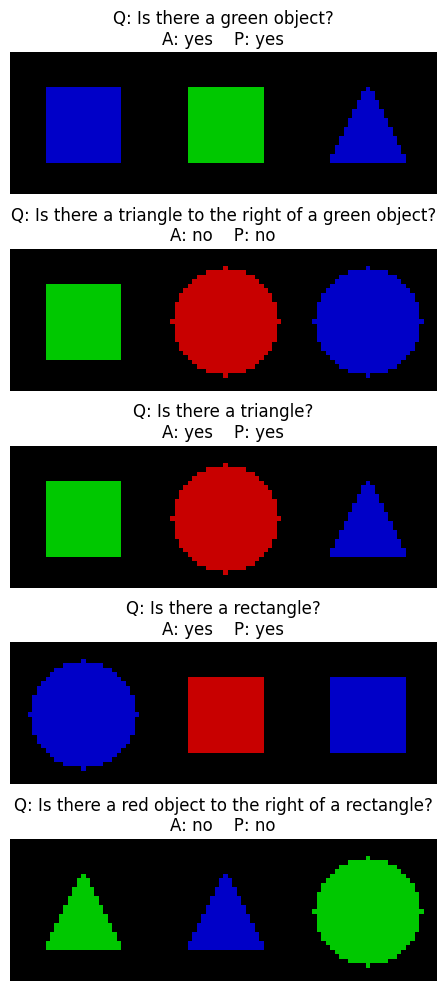

In [10]:
model.eval()

def get_answer(model, image: torch.Tensor, question: str):
    with torch.no_grad():
        outputs = model({'image': image.unsqueeze(0), 'question': [question], 'answer': [None]})
    return outputs['pred_answers'][0]


plt.figure(figsize=(5, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    image, question, answer = test_dataset[i]['image'], test_dataset[i]['question'], test_dataset[i]['answer']
    answer = 'yes' if answer else 'no'
    pred_answer = get_answer(model, image, question)
    plt.imshow(image.permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(f'Q: {question}\nA: {answer}    P: {pred_answer}')
    plt.axis('off')

plt.tight_layout()
plt.show()